https://www.tensorflow.org/hub/tutorials/movinet


!sudo apt install -y ffmpeg

!pip install -q mediapy

!pip uninstall -q -y opencv-python-headless

!pip install -q "opencv-python-headless<4.3"

In [3]:
# Import libraries
import pathlib
import cv2

import matplotlib as mpl
import matplotlib.pyplot as plt
import mediapy as media
import numpy as np
import PIL

import tensorflow as tf
import tensorflow_hub as hub
import tqdm

mpl.rcParams.update({'font.size': 10})

TypeError: Descriptors cannot be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

In [21]:
labels_path = tf.keras.utils.get_file(
    fname='labels.txt',
    origin='https://raw.githubusercontent.com/tensorflow/models/f8af2291cced43fc9f1d9b41ddbf772ae7b0d7d2/official/projects/movinet/files/kinetics_600_labels.txt'
)
labels_path = pathlib.Path(labels_path)

lines = labels_path.read_text().splitlines()
KINETICS_600_LABELS = np.array([line.strip() for line in lines])
KINETICS_600_LABELS[:20]

array(['abseiling', 'acting in play', 'adjusting glasses', 'air drumming',
       'alligator wrestling', 'answering questions', 'applauding',
       'applying cream', 'archaeological excavation', 'archery',
       'arguing', 'arm wrestling', 'arranging flowers',
       'assembling bicycle', 'assembling computer',
       'attending conference', 'auctioning', 'backflip (human)',
       'baking cookies', 'bandaging', 'barbequing', 'bartending',
       'base jumping', 'bathing dog', 'battle rope training',
       'beatboxing', 'bee keeping', 'belly dancing', 'bench pressing',
       'bending back', 'bending metal', 'biking through snow',
       'blasting sand', 'blowdrying hair', 'blowing bubble gum',
       'blowing glass', 'blowing leaves', 'blowing nose',
       'blowing out candles', 'bobsledding', 'bodysurfing', 'bookbinding',
       'bottling', 'bouncing on bouncy castle', 'bouncing on trampoline',
       'bowling', 'braiding hair', 'breading or breadcrumbing',
       'breakdancing',

In [18]:
jumpingjack_url = 'https://github.com/tensorflow/models/raw/f8af2291cced43fc9f1d9b41ddbf772ae7b0d7d2/official/projects/movinet/files/jumpingjack.gif'
jumpingjack_path = tf.keras.utils.get_file(
    fname='jumpingjack.gif',
    origin=jumpingjack_url,
    cache_dir='.', cache_subdir='.',
)

In [19]:
# Read and process a video
def load_gif(file_path, image_size=(224, 224)):
  """Loads a gif file into a TF tensor.

  Use images resized to match what's expected by your model.
  The model pages say the "A2" models expect 224 x 224 images at 5 fps

  Args:
    file_path: path to the location of a gif file.
    image_size: a tuple of target size.

  Returns:
    a video of the gif file
  """
  # Load a gif file, convert it to a TF tensor
  raw = tf.io.read_file(file_path)
  video = tf.io.decode_gif(raw)
  # Resize the video
  video = tf.image.resize(video, image_size)
  # change dtype to a float32
  # Hub models always want images normalized to [0,1]
  # ref: https://www.tensorflow.org/hub/common_signatures/images#input
  video = tf.cast(video, tf.float32) / 255.
  return video

In [4]:
def preprocess_frame(frame):
    # Resize the frame to the input size expected by the MoViNet model
    # frame = cv2.resize(frame, (224, 224))  # Adjust size if your model uses different dimensions
    # # Normalize the frame (0-255 to 0-1)
    frame = frame / 255.0
    frame = frame[0:720, 280:1000]
    frame = cv2.resize(frame, (224, 224))
    return 1 - frame

def load_bite_clip():
    cap = cv2.VideoCapture('raw_session.mp4')
    frames = []
    frame_number = -1

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_number += 1
        if frame_number % 100 == 0:
            print(frame_number)
        if frame_number < 1150 or frame_number % 4 != 0:
            continue
        if frame_number > 1450:
            break

        frame = cv2.flip(frame, 1)
        processed_frame = preprocess_frame(frame)
        frames.append(processed_frame)

    cap.release()

    return tf.cast(frames, tf.float32)

bite_clip = load_bite_clip()


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


In [5]:
bite_clip.numpy().dtype

dtype('float32')

In [6]:
# jumpingjack=load_gif(jumpingjack_path)
# jumpingjack.shape
bite_clip.shape

TensorShape([75, 224, 224, 3])

In [7]:
# @title
# Get top_k labels and probabilities
def get_top_k(probs, k=5, label_map=KINETICS_600_LABELS):
  """Outputs the top k model labels and probabilities on the given video.

  Args:
    probs: probability tensor of shape (num_frames, num_classes) that represents
      the probability of each class on each frame.
    k: the number of top predictions to select.
    label_map: a list of labels to map logit indices to label strings.

  Returns:
    a tuple of the top-k labels and probabilities.
  """
  # Sort predictions to find top_k
  top_predictions = tf.argsort(probs, axis=-1, direction='DESCENDING')[:k]
  # collect the labels of top_k predictions
  top_labels = tf.gather(label_map, top_predictions, axis=-1)
  # decode lablels
  top_labels = [label.decode('utf8') for label in top_labels.numpy()]
  # top_k probabilities of the predictions
  top_probs = tf.gather(probs, top_predictions, axis=-1).numpy()
  return tuple(zip(top_labels, top_probs))

# Base Model

In [ ]:
# @title
%%time
id = 'a2'
mode = 'base'
version = '3'
hub_url = f'https://tfhub.dev/tensorflow/movinet/{id}/{mode}/kinetics-600/classification/{version}'
model = hub.load(hub_url)

CPU times: user 21.9 s, sys: 2.11 s, total: 24 s
Wall time: 27.2 s


In [ ]:
# @title
sig = model.signatures['serving_default']
print(sig.pretty_printed_signature())

Input Parameters:
  image (KEYWORD_ONLY): TensorSpec(shape=(None, None, None, None, 3), dtype=tf.float32, name='image')
Output Type:
  Dict[['classifier_head', TensorSpec(shape=(None, 600), dtype=tf.float32, name='classifier_head')]]
Captures:
  138576881592704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138576587340640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138576587340288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138576587339584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138576587339936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138576881592352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138576587339232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138576587338176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138576587338528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138576587338880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138576881592528: TensorSpec(shape=(), dtype=tf.resourc

In [ ]:
# @title
sig(image = jumpingjack[tf.newaxis, :1])

{'classifier_head': <tf.Tensor: shape=(1, 600), dtype=float32, numpy=
 array([[-1.96466136e+00, -1.57448840e+00,  1.88307738e+00,
          3.35748851e-01, -3.48115134e+00,  2.58532643e+00,
          3.28525043e+00,  7.03559399e-01,  1.26475120e+00,
         -3.85556126e+00,  3.09432745e-02, -7.85710514e-01,
         -4.08661187e-01,  1.02467346e+00, -9.09889579e-01,
          1.04479432e+00,  2.08003688e+00,  1.09493256e+00,
          8.63056064e-01, -9.08083141e-01,  9.78571653e-01,
         -1.78778231e+00,  6.77635252e-01,  4.72949445e-02,
          1.32420182e+00, -4.86524493e-01, -1.49739003e+00,
         -3.82725763e+00,  1.90998733e+00, -7.84629166e-01,
         -4.47119534e-01, -2.71756911e+00,  1.33547568e+00,
          9.61800575e-01,  2.37452656e-01, -2.74495554e+00,
          3.29579258e+00, -4.91338819e-01,  2.13655755e-01,
          1.01261103e+00, -2.94623566e+00, -1.37473321e+00,
         -1.09285510e+00, -7.11687207e-01,  3.58361483e+00,
         -1.64505768e+00, -1.3

In [ ]:
# @title
%%time
logits = sig(image = jumpingjack[tf.newaxis, ...])
logits = logits['classifier_head'][0]

print(logits.shape)
print()

(600,)

CPU times: user 34.2 s, sys: 123 ms, total: 34.3 s
Wall time: 26.9 s


In [ ]:
# @title
probs = tf.nn.softmax(logits, axis=-1)
for label, p in get_top_k(probs):
  print(f'{label:20s}: {p:.3f}')

jumping jacks       : 0.834
zumba               : 0.008
lunge               : 0.003
doing aerobics      : 0.003
polishing metal     : 0.002


# Stream Model

In [8]:
%%time
id = 'a2'
mode = 'stream'
version = '3'
hub_url = f'https://tfhub.dev/tensorflow/movinet/{id}/{mode}/kinetics-600/classification/{version}'
model = hub.load(hub_url)

CPU times: total: 24.3 s
Wall time: 54.6 s


In [8]:
list(model.signatures.keys())

['call', 'init_states']

In [9]:
lines = model.signatures['init_states'].pretty_printed_signature().splitlines()
print('.\n'.join(lines))

Input Parameters:.
  input_shape (KEYWORD_ONLY): TensorSpec(shape=(5,), dtype=tf.int32, name='input_shape').
Output Type:.
  Dict[['state/b4/l2/pool_buffer', TensorSpec(shape=(None, 1, 1, 1, 384), dtype=tf.float32, name='state/b4/l2/pool_buffer')], ['state/b1/l2/pool_buffer', TensorSpec(shape=(None, 1, 1, 1, 96), dtype=tf.float32, name='state/b1/l2/pool_buffer')], ['state/b1/l1/pool_frame_count', TensorSpec(shape=(1,), dtype=tf.int32, name='state/b1/l1/pool_frame_count')], ['state/b1/l0/pool_frame_count', TensorSpec(shape=(1,), dtype=tf.int32, name='state/b1/l0/pool_frame_count')], ['state/b2/l2/pool_buffer', TensorSpec(shape=(None, 1, 1, 1, 240), dtype=tf.float32, name='state/b2/l2/pool_buffer')], ['state/b4/l0/pool_frame_count', TensorSpec(shape=(1,), dtype=tf.int32, name='state/b4/l0/pool_frame_count')], ['state/b3/l1/pool_frame_count', TensorSpec(shape=(1,), dtype=tf.int32, name='state/b3/l1/pool_frame_count')], ['state/b3/l4/pool_buffer', TensorSpec(shape=(None, 1, 1, 1, 144), dty

In [11]:
# Equivalent
# jumpingjack[tf.newaxis, ...].shape
# tf.expand_dims(jumpingjack, axis=0).shape

NameError: name 'jumpingjack' is not defined

In [9]:
# initial_state = model.init_states(jumpingjack[tf.newaxis, ...].shape)
initial_state = model.init_states(bite_clip[tf.newaxis, ...].shape)

In [65]:
initial_state['state/b2/l3/pool_buffer']

<tf.Tensor: shape=(1, 1, 1, 1, 192), dtype=float32, numpy=
array([[[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]]],
      dtype=float32)>

In [66]:
list(sorted(initial_state.keys()))[:12]

['state/b0/l0/pool_buffer',
 'state/b0/l0/pool_frame_count',
 'state/b0/l1/pool_buffer',
 'state/b0/l1/pool_frame_count',
 'state/b0/l1/stream_buffer',
 'state/b0/l2/pool_buffer',
 'state/b0/l2/pool_frame_count',
 'state/b0/l2/stream_buffer',
 'state/b1/l0/pool_buffer',
 'state/b1/l0/pool_frame_count',
 'state/b1/l0/stream_buffer',
 'state/b1/l1/pool_buffer']

In [67]:
inputs = initial_state.copy()

print(inputs.get('image'))

# Add the batch axis, take the first frme, but keep the frame-axis.
# inputs['image'] = jumpingjack[tf.newaxis, 0:1, ...]
inputs['image'] = bite_clip[tf.newaxis, 0:1, ...]

None


In [68]:
# warmup
model(inputs)

(<tf.Tensor: shape=(1, 600), dtype=float32, numpy=
 array([[ 8.86642635e-01, -1.09468865e+00, -2.21400523e+00,
          6.68858290e-01, -1.93871939e+00,  2.65796924e+00,
         -9.84224498e-01,  9.41119134e-01,  4.71089810e-01,
         -6.28494322e-01,  1.02469826e+00, -1.72018552e+00,
          5.26227951e+00,  7.44642496e-01, -2.59863544e+00,
          2.83894110e+00,  4.48024720e-01,  2.13216805e+00,
         -2.31477186e-01, -4.51056570e-01, -3.97490799e-01,
         -8.63624573e-01, -6.61040246e-02,  1.90063536e+00,
          2.16010261e+00,  1.33442020e+00, -2.57033587e+00,
         -3.16127896e-01,  9.09049988e-01,  1.57151163e+00,
         -2.74494004e+00, -2.23827511e-02,  3.79709005e-01,
         -3.57630730e-01,  2.47956061e+00, -1.01594305e+00,
         -1.01691425e+00,  9.57925916e-01, -3.86799872e-02,
          2.91346216e+00, -2.47517705e-01, -5.23398733e+00,
          1.22273374e+00,  3.15651560e+00,  1.95245981e+00,
          6.69993311e-02,  1.65624714e+00,  1.673

In [ ]:
logits, new_state = model(inputs)
logits = logits[0]
probs = tf.nn.softmax(logits, axis=-1)

for label, p in get_top_k(probs):
  print(f'{label:20s}: {p:.3f}')

print()

arranging flowers   : 0.074
making a cake       : 0.058
getting a haircut   : 0.038
trimming or shaving beard: 0.035
shearing sheep      : 0.028



In [72]:
%%time
state = initial_state.copy()
all_logits = []

for n in range(len(bite_clip)):
  inputs = state
  inputs['image'] = bite_clip[tf.newaxis, n:n+1, ...]
  result, state = model(inputs)
  all_logits.append(logits)

probabilities = tf.nn.softmax(all_logits, axis=-1)

arranging flowers   : 0.074
making a cake       : 0.058
getting a haircut   : 0.038
trimming or shaving beard: 0.035
shearing sheep      : 0.028
CPU times: total: 2.75 s
Wall time: 11.5 s


In [80]:
for label, p in get_top_k(probabilities[1]):
  print(f'{label:20s}: {p:.3f}')

arranging flowers   : 0.074
making a cake       : 0.058
getting a haircut   : 0.038
trimming or shaving beard: 0.035
shearing sheep      : 0.028


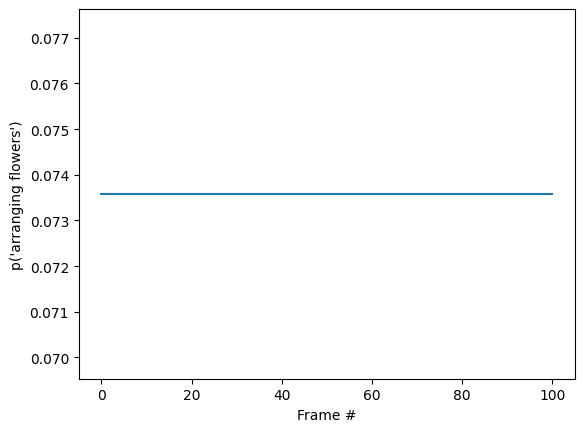

In [74]:
id = tf.argmax(probabilities[-1])
plt.plot(probabilities[:, id])
plt.xlabel('Frame #')
plt.ylabel(f"p('{KINETICS_600_LABELS[id]}')");

In [98]:
for label, p in get_top_k(tf.reduce_mean(probabilities, axis=0)):
  print(f'{label:20s}: {p:.3f}')

golf chipping       : 0.427
tackling            : 0.134
lunge               : 0.056
stretching arm      : 0.053
passing american football (not in game): 0.039


In [14]:
# Get top_k labels and probabilities predicted using MoViNets streaming model
# def get_top_k_streaming_labels(probs, k=5, label_map=KINETICS_600_LABELS):
#   """Returns the top-k labels over an entire video sequence.

#   Args:
#     probs: probability tensor of shape (num_frames, num_classes) that represents
#       the probability of each class on each frame.
#     k: the number of top predictions to select.
#     label_map: a list of labels to map logit indices to label strings.

#   Returns:
#     a tuple of the top-k probabilities, labels, and logit indices
#   """
#   top_categories_last = tf.argsort(probs, -1, 'DESCENDING')[-1, :1]
#   # Sort predictions to find top_k
#   categories = tf.argsort(probs, -1, 'DESCENDING')[:, :k]
#   categories = tf.reshape(categories, [-1])

#   counts = sorted([
#       (i.numpy(), tf.reduce_sum(tf.cast(categories == i, tf.int32)).numpy())
#       for i in tf.unique(categories)[0]
#   ], key=lambda x: x[1], reverse=True)

#   top_probs_idx = tf.constant([i for i, _ in counts[:k]])
#   top_probs_idx = tf.concat([top_categories_last, top_probs_idx], 0)
#   # find unique indices of categories
#   top_probs_idx = tf.unique(top_probs_idx)[0][:k+1]
#   # top_k probabilities of the predictions
#   top_probs = tf.gather(probs, top_probs_idx, axis=-1)
#   top_probs = tf.transpose(top_probs, perm=(1, 0))
#   # collect the labels of top_k predictions
#   top_labels = tf.gather(label_map, top_probs_idx, axis=0)
#   # decode the top_k labels
#   top_labels = [label.decode('utf8') for label in top_labels.numpy()]

#   return top_probs, top_labels, top_probs_idx

def get_top_k_labels(probs, frame_i, k=5, label_map=KINETICS_600_LABELS):
  """Returns the top-k labels over an entire video sequence.

  Args:
    probs: probability tensor of shape (num_frames, num_classes) that represents
      the probability of each class on each frame.
    k: the number of top predictions to select.
    label_map: a list of labels to map logit indices to label strings.

  Returns:
    a tuple of the top-k probabilities, labels, and logit indices
  """
  top_categories_last = tf.argsort(probs, -1, 'DESCENDING')[frame_i, :1]
  # Sort predictions to find top_k
  categories = tf.argsort(probs, -1, 'DESCENDING')[:, :k]
  categories = tf.reshape(categories, [-1])

  counts = sorted([
      (i.numpy(), tf.reduce_sum(tf.cast(categories == i, tf.int32)).numpy())
      for i in tf.unique(categories)[0]
  ], key=lambda x: x[1], reverse=True)

  top_probs_idx = tf.constant([i for i, _ in counts[:k]])
  top_probs_idx = tf.concat([top_categories_last, top_probs_idx], 0)
  # find unique indices of categories
  top_probs_idx = tf.unique(top_probs_idx)[0][:k+1]
  # top_k probabilities of the predictions
  top_probs = tf.gather(probs, top_probs_idx, axis=-1)
  top_probs = tf.transpose(top_probs, perm=(1, 0))
  # collect the labels of top_k predictions
  top_labels = tf.gather(label_map, top_probs_idx, axis=0)
  # decode the top_k labels
  top_labels = [label.decode('utf8') for label in top_labels.numpy()]

  return top_probs, top_labels


# Plot top_k predictions at a given time step
def plot_streaming_top_preds_at_step(
    step=None,
    image=None,
    legend_loc='lower left',
    duration_seconds=10,
    figure_height=500,
    playhead_scale=0.8,
    grid_alpha=0.3):
  """Generates a plot of the top video model predictions at a given time step.

  Args:
    top_probs: a tensor of shape (k, num_frames) representing the top-k
      probabilities over all frames.
    top_labels: a list of length k that represents the top-k label strings.
    step: the current time step in the range [0, num_frames].
    image: the image frame to display at the current time step.
    legend_loc: the placement location of the legend.
    duration_seconds: the total duration of the video.
    figure_height: the output figure height.
    playhead_scale: scale value for the playhead.
    grid_alpha: alpha value for the gridlines.

  Returns:
    A tuple of the output numpy image, figure, and axes.
  """

#   top_probs, top_labels = get_top_k_labels(probs, step)

  # find number of top_k labels and frames in the video
  # Visualize frames and top_k probabilities of streaming video
  fig = plt.figure(figsize=(6.5, 7), dpi=300)
  gs = mpl.gridspec.GridSpec(8, 1)
  ax2 = plt.subplot(gs[:-3, :])
  ax = plt.subplot(gs[-3:, :])
  # display the frame
  if image is not None:
    ax2.imshow(image, interpolation='nearest')
    ax2.axis('off')

  # x-axis (frame number)
#   preview_line_x = tf.linspace(0., duration_seconds, num_frames)
  # y-axis (top_k probabilities)
#   preview_line_y = top_probs

#   line_x = preview_line_x[:step+1]
#   line_y = preview_line_y[:, :step+1]

#   for i in range(num_labels):
#     ax.plot(preview_line_x, preview_line_y[i], label=None, linewidth='1.5',
#             linestyle=':', color='gray')
#     ax.plot(line_x, line_y[i], label=top_labels[i], linewidth='2.0')


#   ax.grid(which='major', linestyle=':', linewidth='1.0', alpha=grid_alpha)
#   ax.grid(which='minor', linestyle=':', linewidth='0.5', alpha=grid_alpha)

#   min_height = tf.reduce_min(top_probs) * playhead_scale
#   max_height = tf.reduce_max(top_probs)
#   ax.vlines(preview_line_x[step], min_height, max_height, colors='red')
#   ax.scatter(preview_line_x[step], max_height, color='red')

#   ax.legend(loc=legend_loc)

#   plt.xlim(0, duration_seconds)
#   plt.ylabel('Probability')
#   plt.xlabel('Time (s)')
#   plt.yscale('log')

  final_probs = probs[step]
  y = 0.8
  for label, p in get_top_k(final_probs):
    # print(f'{label:20s}: {p:.3f}')
    # print(f'{label:20s}', end=', ')
    plt.text(0, y, f'{label:20s}', fontsize=35, color='red')
    y -= 0.2
  plt.text(0, y, f'Frame: {step}', fontsize=35, color='red')

#   print()

#   plt.text(0, 0.8, "Hello, World 1!", fontsize=35, color='red')
#   plt.text(0, 0.6, "Hello, World 2!", fontsize=35, color='red')
#   plt.text(0, 0.4, "Hello, World 3!", fontsize=35, color='red')
#   plt.text(0, 0.2, "Hello, World 4!", fontsize=35, color='red')
#   plt.text(0, 0, "Hello, World!5", fontsize=35, color='red')


  fig.tight_layout()
  fig.canvas.draw()

  data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
  plt.close()

  figure_width = int(figure_height * data.shape[1] / data.shape[0])
  image = PIL.Image.fromarray(data).resize([figure_width, figure_height])
  image = np.array(image)

  return image

# Plotting top_k predictions from MoViNets streaming model
def plot_streaming_top_preds(
    probs,
    video,
    top_k=5,
    video_fps=25.,
    figure_height=500,
    use_progbar=True):
  """Generates a video plot of the top video model predictions.

  Args:
    probs: probability tensor of shape (num_frames, num_classes) that represents
      the probability of each class on each frame.
    video: the video to display in the plot.
    top_k: the number of top predictions to select.
    video_fps: the input video fps.
    figure_fps: the output video fps.
    figure_height: the height of the output video.
    use_progbar: display a progress bar.

  Returns:
    A numpy array representing the output video.
  """
  # select number of frames per second
  video_fps = 8.
  # select height of the image
  figure_height = 500
  # number of time steps of the given video
  steps = video.shape[0]
  # estimate duration of the video (in seconds)
  duration = steps / video_fps
  # estimate top_k probabilities and corresponding labels
#   top_probs, top_labels, _ = get_top_k_streaming_labels(probs, k=top_k)

  images = []
  step_generator = tqdm.trange(steps) if use_progbar else range(steps)
  for i in step_generator:
    image = plot_streaming_top_preds_at_step(
        step=i,
        image=video[i],
        duration_seconds=duration,
        figure_height=figure_height,
    )
    images.append(image)

  return np.array(images)

# Skip to here

In [10]:
init_states = model.init_states(bite_clip[tf.newaxis].shape)

In [12]:
# Insert your video clip here
video = 1 - bite_clip
# video = tf.gather(video, indices=[2, 1, 0], axis=-1)
images = tf.split(video[tf.newaxis], video.shape[0], axis=1)

all_logits = []

# To run on a video, pass in one frame at a time
states = init_states
for i, image in enumerate(images):
  print(f'{i}/{len(images)}')
  # predictions for each frame
  if i > 0 and i % 20 == 0:
    states = init_states
  logits, states = model({**states, 'image': image})

  for label, p in get_top_k(logits[0]):
    print(label, end=', ')
  print()

  all_logits.append(logits)

# concatenating all the logits
logits = tf.concat(all_logits, 0)
# estimating probabilities
probs = tf.nn.softmax(logits, axis=-1)

0/75
playing squash or racquetball, scrubbing face, applying cream, lunge, zumba, 
1/75
answering questions, yoga, news anchoring, raising eyebrows, staring, 
2/75
answering questions, chewing gum, yoga, news anchoring, burping, 
3/75
chewing gum, answering questions, eating burger, tasting food, eating chips, 
4/75
chewing gum, answering questions, eating burger, tasting food, eating chips, 
5/75
chewing gum, answering questions, eating burger, eating watermelon, tasting food, 
6/75
answering questions, chewing gum, eating burger, singing, attending conference, 
7/75
answering questions, singing, chewing gum, staring, attending conference, 
8/75
answering questions, eating watermelon, attending conference, chewing gum, singing, 
9/75
eating watermelon, tasting food, sucking lolly, eating ice cream, eating chips, 
10/75
tasting food, sucking lolly, eating watermelon, eating ice cream, eating carrots, 
11/75
tasting food, eating ice cream, sucking lolly, eating cake, eating carrots, 
12

In [16]:
final_probs = probs[-1]
print('Top_k predictions and their probablities\n')
for label, p in get_top_k(final_probs):
  print(f'{label:20s}: {p:.3f}')

Top_k predictions and their probablities

chewing gum         : 0.118
eating chips        : 0.058
blowing bubble gum  : 0.052
answering questions : 0.039
staring             : 0.035


In [15]:
# Generate a plot and output to a video tensor
plot_video = plot_streaming_top_preds(probs, video, video_fps=8., top_k=15)

  0%|          | 0/75 [00:00<?, ?it/s]

C:\Users\Evan Mazor\AppData\Local\Temp\ipykernel_17128\89590184.py:164: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
100%|██████████| 75/75 [00:37<00:00,  1.97it/s]


In [18]:
import cv2

def save_images(images, filename, fps=20.0):
    # Define the codec and create VideoWriter object
    # 'XVID' is a commonly used codec. You can replace it with 'MJPG', 'X264', etc.
    # Use 'mp4v' codec for MP4 files
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    output_file = f'{filename}.mp4'  # Output video file name
    height, width, channels = images[0].shape

    # Initialize the video writer
    video_writer = cv2.VideoWriter(output_file, fourcc, fps, (width, height))

    # Loop through each image and write it to the video
    for image in images:
        video_writer.write(image)

    # Release the video writer object
    video_writer.release()

In [145]:
bite_clip = np.fromfile('bite_clip.raw', dtype=np.float32) * 255
bite_clip = bite_clip.astype(np.uint8).reshape((8, 224, 224, 3))
bite_clip.shape

(8, 224, 224, 3)

In [ ]:
# @title
# Get top_k labels and probabilities
def get_top_k(probs, k=5, label_map=KINETICS_600_LABELS):
  """Outputs the top k model labels and probabilities on the given video.

  Args:
    probs: probability tensor of shape (num_frames, num_classes) that represents
      the probability of each class on each frame.
    k: the number of top predictions to select.
    label_map: a list of labels to map logit indices to label strings.

  Returns:
    a tuple of the top-k labels and probabilities.
  """
  # Sort predictions to find top_k
  top_predictions = tf.argsort(probs, axis=-1, direction='DESCENDING')[:k]
  # collect the labels of top_k predictions
  top_labels = tf.gather(label_map, top_predictions, axis=-1)
  # decode lablels
  top_labels = [label.decode('utf8') for label in top_labels.numpy()]
  # top_k probabilities of the predictions
  top_probs = tf.gather(probs, top_predictions, axis=-1).numpy()
  return tuple(zip(top_labels, top_probs))

In [19]:
# For gif format, set codec='gif'
save_images(plot_video, 'biteclip_probabilities_v4', fps=8)
# save_images((bite_clip.numpy() * 255).astype(np.uint8), 'bite_clip', fps=30)
# save_images((jumpingjack.numpy() * 255).astype(np.uint8), 'jjack', fps=3)
# media.show_video(plot_video, fps=3)